# Image classification with convolutional neural networks

In this script we create, train, and evaluate an image classifier based on convolutional neural networks (CNNs).

In [47]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [48]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [49]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Just like MNIST, you can download the data by setting 'download=True' directly from pytorch
train_data = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=torchvision.transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

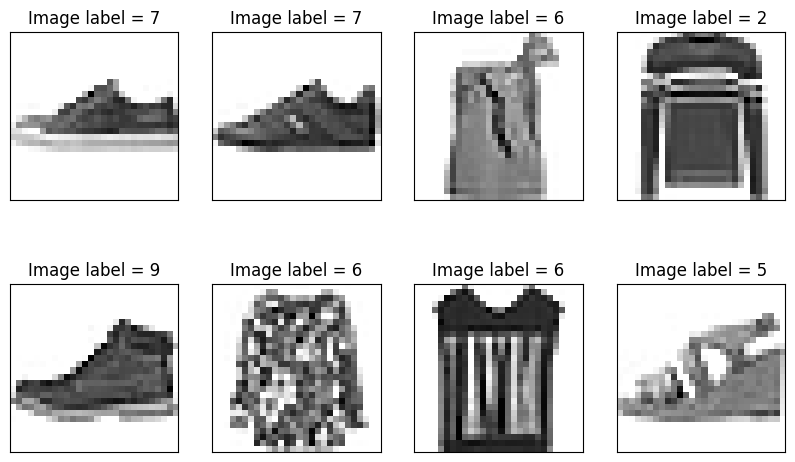

In [50]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules that produce intermediate latent representations called ***feature maps***
- an output linear layer performing classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [51]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [52]:
# TO DO: create the second CNN layer, with the same structure as the first one
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.


torch.Size([8, 32, 7, 7])


In [53]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate parameters
# - the input size is given by checking the shape of 'out_vec'
input_size = out_vec.shape[1]
output_size =  num_classes
linear_layer = nn.Linear(input_size, output_size)
output = linear_layer(out_vec)
print(output.shape)
# - the output size is the number of classes in the dataset
# Once defined, apply this layer to out_vec


torch.Size([8, 1568])
torch.Size([8, 10])


### General module

Now, let's create a general CNN classification network, train and test it. The CNN module takes as inputs the number of output channels in each layer (and the number of classes), but we also have to explicitly provide the input size of the Linear layer, since it depends on many other parameters (image size, but also kernel, padding, stride, number of channels in the convolutions...). Instead of computing it with a general (and heavy) formula, it's easier to just get it from an example (as above), and then pass it as an input parameter.

**Note**: there are ways to alleviate this issue (e.g., using another convolution layer with as many kernels as output classes, and then global pooling)... but that's outside the scope of these labs.

In [54]:
class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(input_size_linear, num_classes)
        
    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        return out


In [55]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(input_size, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
torch.manual_seed(0)
model.apply(init_params)

Total number of parameters:  28938


CNNClassif(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_layer): Linear(in_features=1568, out_features=10, bias=True)
)

## Training and evaluation

The evaluation and training function (with validation) are almost the same as in lab4.1, except we don't need to vectorize the images. Indeed, MLPs process (batches of) vectors, while CNNs directly process (batches of) images.

<span style="color:red">**Exercice 3**</span> Write the evaluation and training function with validation. Train the model using the training parameters below, and plot the training loss and validation accuracy over epochs. Compute the test accuracy.

In [56]:
# Training parameters
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

In [57]:
def eval_cnn_classifier(model, eval_dataloader):


    model.eval() 

    
    with torch.no_grad():
       
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [58]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    

    train_losses = []
    accuracy = []
    
    # Training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # forward pass
            y = model_tr(images)
            loss = loss_fn(y, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)

        valid_acc = eval_cnn_classifier(model_tr,valid_dataloader)
        accuracy.append(valid_acc)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss, valid_acc))

        
    return model_tr, train_losses, accuracy

In [59]:
model, loss, accuracy = training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/40], Training loss: 1.9798, Accuracy: 31.0000
Epoch [2/40], Training loss: 1.4981, Accuracy: 44.0000
Epoch [3/40], Training loss: 1.5709, Accuracy: 48.0000
Epoch [4/40], Training loss: 0.7158, Accuracy: 48.0000
Epoch [5/40], Training loss: 1.2324, Accuracy: 61.0000
Epoch [6/40], Training loss: 1.1043, Accuracy: 61.0000
Epoch [7/40], Training loss: 0.5045, Accuracy: 64.0000
Epoch [8/40], Training loss: 1.5940, Accuracy: 59.0000
Epoch [9/40], Training loss: 0.4056, Accuracy: 54.0000
Epoch [10/40], Training loss: 0.6923, Accuracy: 65.0000
Epoch [11/40], Training loss: 0.8025, Accuracy: 69.0000
Epoch [12/40], Training loss: 0.6956, Accuracy: 65.0000
Epoch [13/40], Training loss: 0.9896, Accuracy: 66.0000
Epoch [14/40], Training loss: 0.2915, Accuracy: 69.0000
Epoch [15/40], Training loss: 1.4423, Accuracy: 73.0000
Epoch [16/40], Training loss: 0.2844, Accuracy: 65.0000
Epoch [17/40], Training loss: 0.3248, Accuracy: 76.0000
Epoch [18/40], Training loss: 0.6642, Accuracy: 75.0000
E

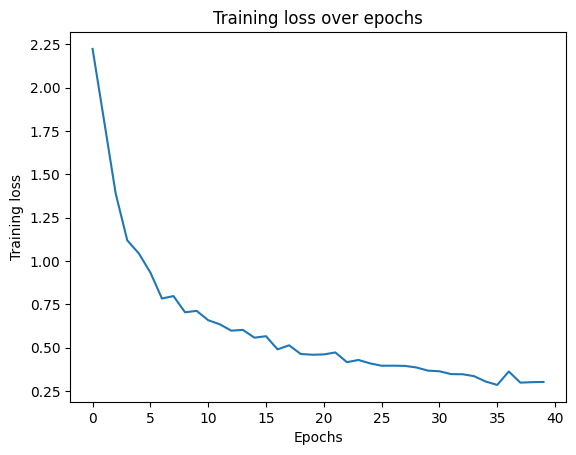

In [60]:
plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.show()

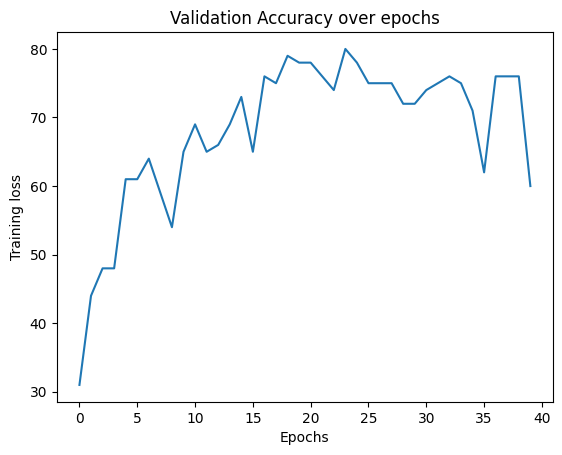

In [61]:
plt.figure()
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Validation Accuracy over epochs')
plt.show()

In [62]:
# model = CNNClassif(input_size, num_channels1, num_channels2, num_classes)
accuracy_test = eval_cnn_classifier(model, train_dataloader)
print(f'Accuracy on test images: {accuracy_test} ')

Accuracy on test images: 79.5 


## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [63]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.
class CNNClassif_batch(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(input_size_linear, num_classes)
    
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out



In [64]:
# TO DO:
# - instantiate the model and initialize its parameters
model_batch = CNNClassif_batch(input_size, num_channels1, num_channels2, num_classes)
torch.manual_seed(0)
model_batch.apply(init_params)
# - train it, and plot the training and validation losses
model_batch, loss_batch, accuracy_batch = training_cnn_classifier(model_batch, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)
# - compute and print the test accuracy


Epoch [1/40], Training loss: 0.6754, Accuracy: 61.0000
Epoch [2/40], Training loss: 0.3303, Accuracy: 75.0000
Epoch [3/40], Training loss: 0.1952, Accuracy: 70.0000
Epoch [4/40], Training loss: 0.1520, Accuracy: 68.0000
Epoch [5/40], Training loss: 0.3393, Accuracy: 70.0000
Epoch [6/40], Training loss: 0.3153, Accuracy: 72.0000
Epoch [7/40], Training loss: 0.0154, Accuracy: 69.0000
Epoch [8/40], Training loss: 0.0473, Accuracy: 69.0000
Epoch [9/40], Training loss: 0.0106, Accuracy: 71.0000
Epoch [10/40], Training loss: 0.0314, Accuracy: 73.0000
Epoch [11/40], Training loss: 0.0554, Accuracy: 74.0000
Epoch [12/40], Training loss: 0.0440, Accuracy: 71.0000
Epoch [13/40], Training loss: 0.0235, Accuracy: 72.0000
Epoch [14/40], Training loss: 0.0118, Accuracy: 74.0000
Epoch [15/40], Training loss: 0.0263, Accuracy: 75.0000
Epoch [16/40], Training loss: 0.0162, Accuracy: 71.0000
Epoch [17/40], Training loss: 0.0060, Accuracy: 70.0000
Epoch [18/40], Training loss: 0.0092, Accuracy: 73.0000
E

In [65]:
print(len(accuracy_batch))

40


In [66]:
accuracy_test = eval_cnn_classifier(model_batch, test_dataloader)
print(f'Accuracy on test images: {accuracy_test}%')

Accuracy on test images: 90.0%


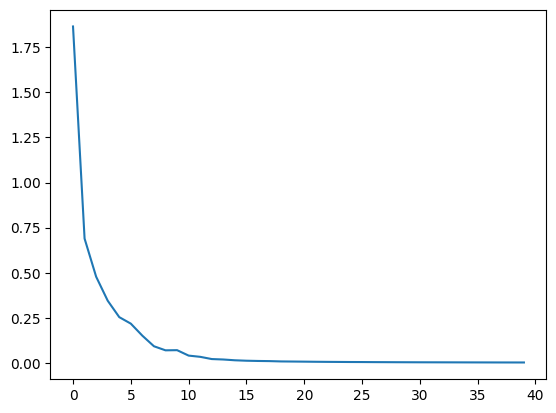

In [67]:
plt.plot(loss_batch)
plt.show()

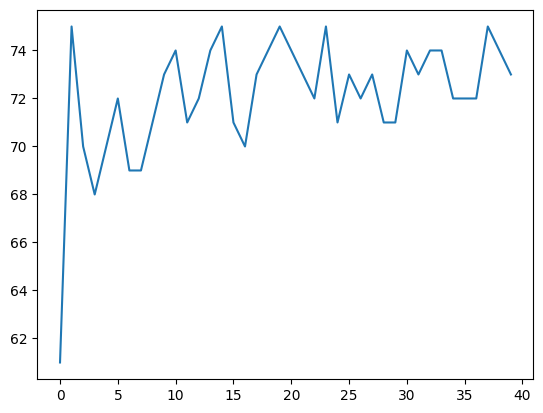

In [68]:
plt.plot(accuracy_batch)
plt.show()

<span style="color:red">**Exercice 4**</span> On a single plot, display the training loss with and without batch norm. On another plot, display the validation accuracy with and without batch norm. What do you conclude?

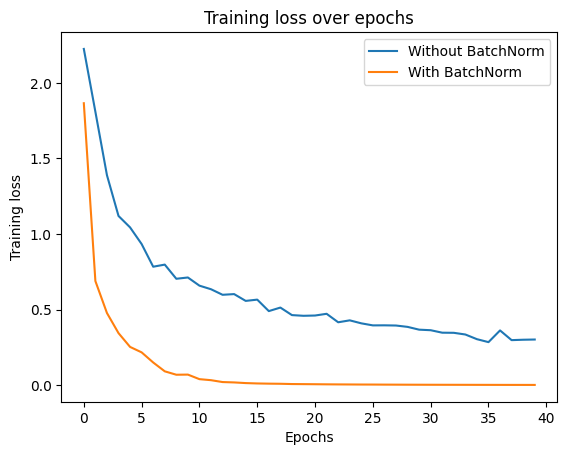

In [69]:
plt.figure()
plt.plot(loss, label = 'Without BatchNorm')
plt.plot(loss_batch, label = 'With BatchNorm')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.legend()
plt.show()

<span style="color:blue"> **In both with and without batch norm, the loss start high but decreases much faster and converges in the model with BatchNorm. By the 15th epoch, the BathcNorm model's loss is already ~0 which suggests that it is learning more effectively and faster while that without batch norm is stil at ~0.5 at the 40th epoch. Also, with batch the training loss is smooth while without batch it isn't as it has more oscillation** </span>

<span style="color:blue"> Batch Normalization improves the training process by allowing the network to converge faster and potentially generalize better. It leads to smoother and faster reduction in training loss.</span>


In [70]:
print(len(accuracy))

40


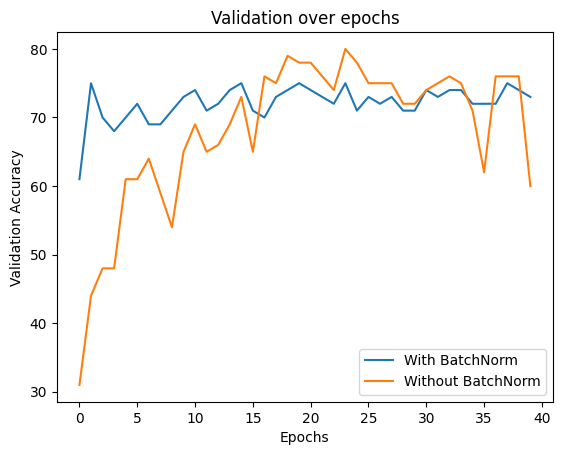

In [71]:
plt.figure()
plt.plot(accuracy_batch, label = ['With BatchNorm'])
plt.plot(accuracy, label = ['Without BatchNorm'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation over epochs')
plt.legend()
plt.show()

<span style="color:blue">**Both validation accuracy accuracies fluctuate very much at the during of the training but the model's. Without batch norm, the accuracy starts very low before increasing  and reaching similar levels to the model with BatchNorm. However, the validation accuracy fluctuates much more, with sharp rises and drops. These fluctuations suggest instability in the learning process. The drop at the end of the training could suggest overfitting
- With batch norm the accuracy starts high and stabilizes with minor fluctuations. It converges early and fluctuates less, indicating better generalization performance.**</span>